# Materials associated with the paper: 

Cao, W., Williams, S., Flament, N., Zahirovic, S., Scotese, C., and Müller, R. D., 2018. Paleolatitudinal distribution of lithologic indicators of climate in a paleogeographic framework. Geological Magazine, 1-24. doi:10.1017/S0016756818000110.

### This Jupyter notebook is used to generate Figures 1-4 for the paper.

The code in this notebook is written in Python 2.7. It utilises the standard scientific Python modules including numpy, pandas, mpl_toolkits, matplotlib, os, and the open source module 'pygplates' which provides a Python API to the GPlates software (https://www.gplates.org/).


## Import Python modules

In [7]:
from mpl_toolkits.basemap import Basemap
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import pandas as pd    
from matplotlib import colors
from matplotlib import legend
import pygplates
from matplotlib.patches import Polygon
import glob, os
from IPython.display import Image
#%matplotlib inline

## Figure 1

### Read the input data

In [8]:
# input the lithologic data - PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge
point_feature_filename_coals = '../Data/Lithologic_Data/PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge.shp'
input_feature_collection_coals = pygplates.FeatureCollection(point_feature_filename_coals)

# read the rotation file
input_rotation_filename_Matthews2016PMAG_fixed = ['../Data/Tectonic_model/Global_EB_410-0Ma_GK07_Matthews_etal_PMAG_fixed_crossovers.rot']
rotation_model = pygplates.RotationModel(input_rotation_filename_Matthews2016PMAG_fixed)

# read contient polygons file
continental_polygons = pygplates.FeatureCollection('../Data/Tectonic_model/ContPolys/PresentDay_ContinentalPolygons_Matthews++.shp')


### Set the ages for the data 

In [9]:
# the ages of the data points
age_range_list = [(419,393),   # Early Devonian
           (393,388),   # Middle Devonian (Eifelian)
           (388,383),   # Middle Devonian (Givetian)
           (383,359),   # Late Devonian
           (359,331),   # Early Carboniferous (Tournaisian-Visean)
           (331,323),   # Early Carboniferous (Serpukhovian)
           (323,307),   # Late Carboniferous (Bashkirian-Moscovian)
           (307,299),   # Late Carboniferous (Kasimovian-Gzhelian)
           (299,290),   # Early Permian (Asselian-Sakmarian)
           (290,252),   # Middle-Late Permian (Artinskian-Lopingian)
           (252,247),   # Early Triassic
           (247,237),   # Middle Triassic
           (237,201),   # Late Triassic
           (201,164),   # Early and Middle Jurassic
           (164,145),   # Late Jurassic
           (145,113),   # Early Cretaceous (Berriasian-Aptian)
           (113,89.8),   # Late Cretaceous (Albian-Turonian)
           (89.8,66.0),   # Late Cretaceous (Coniacian-Maastrichtian)
           (66.0,56.0),   # Paleocene
           (56.0,47.8),  # Early Eocene (Ypresian?)
           (47.8,33.9),  # Middle and Late Eocene
           (33.9,23.0),  # Oligocene
           (23.0,5.3),    # Miocene
           (0.01,-0.01)]

i = 0
for i in np.arange(0,24,1):
    Age = np.mean(age_range_list[i])
    print(Age)

406.0
390.5
385.5
371.0
345.0
327.0
315.0
303.0
294.5
271.0
249.5
242.0
219.0
182.5
154.5
129.0
101.4
77.9
61.0
51.9
40.85
28.45
14.15
0.0


### Define the function for reconstructing the data points back in time

In [10]:
# define a function for reconstructing the data points back in time
def get_paleolithology(point_features,rotation_model):
    pX = []
    pY = []
    pAge = []
    LithCode=[]
    reconstructed_points = []
    for point in input_feature_collection_coals:
        lithcode = point.get_shapefile_attribute('LithCode')
        #if lithcode == 'C' and point.get_reconstruction_plate_id()!=0:
        #if lithcode == 'E' and point.get_reconstruction_plate_id()!=0:
        #if lithcode== 'T' or lithcode=='D' or lithcode=='G' and point.get_reconstruction_plate_id()!=0:
        BirthTime = np.median(point.get_valid_time())
        if BirthTime<410:
            pAge.append(BirthTime)
            point_rotation = rotation_model.get_rotation(BirthTime, point.get_reconstruction_plate_id(), anchor_plate_id=0) #obtain rotating rules
            reconstructed_point = point_rotation * point.get_geometry() # carry out reconstruction
            pX.append(reconstructed_point.to_lat_lon()[1])
            pY.append(reconstructed_point.to_lat_lon()[0])
            reconstructed_points.append(point)
            LithCode.append(point.get_shapefile_attribute('LithCode'))
    return pX,pY,pAge,LithCode

# reconstruct all data and get their x, y coordinates and ages
pX,pY,pAge,LithCode = get_paleolithology(input_feature_collection_coals,rotation_model)
data_xy = []
data_xy = list(zip(LithCode,pY,pX,pAge))
#print data_xy

### Make the figure

406.0

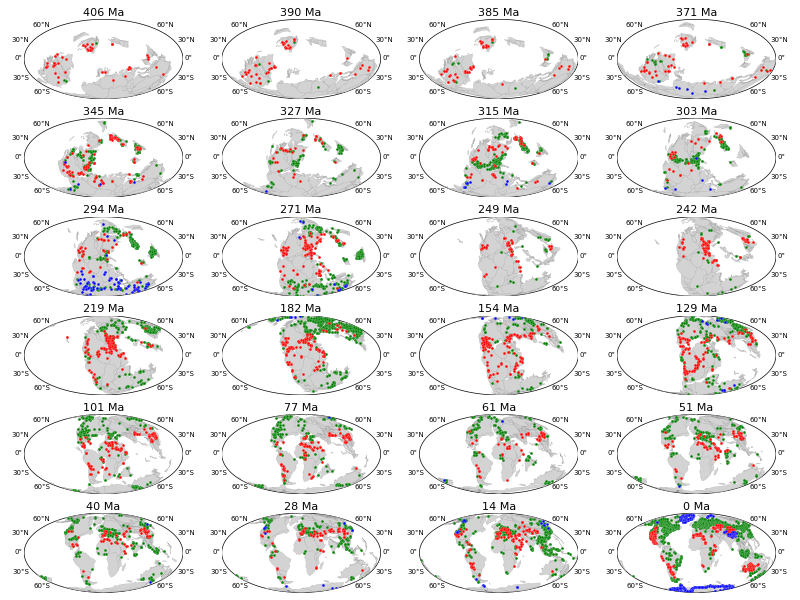

In [11]:
fig, ax = plt.subplots(figsize=(16,12))

for i in np.arange(0,24,1):
    
    #fig, ax = plt.subplots(figsize=(6,4))
    ax = plt.subplot(6,4,i+1)
    
    # Reconstruct Continental Polygons
    age = np.mean(age_range_list[i])
    print(age)
    output_continent = 'temp.shp'
    pygplates.reconstruct(continental_polygons,rotation_model,output_continent,age,anchor_plate_id=0)    
    
    # plot continental polygons
    # resolution: c (crude), l (low), i (intermediate), h (high), f (full) or None
    m = Basemap(projection='moll',lat_0=0,lon_0=0,resolution='c', ax=ax)
    
    m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,0],color='white', textcolor='black',linewidth=0.0)
    m.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='white', textcolor='black',linewidth=0.0)
    
    shp_info = m.readshapefile('temp','shp',drawbounds=False,color='red')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='lightgrey',edgecolor='grey',linewidth=0.2)
        ax.add_patch(poly)
    
    # plot the lithologic data
    x,y = m(np.asarray(pX),np.asarray(pY))
    # Coals
    index = np.where((np.array(pAge) == np.mean(age_range_list[i])) & (np.array(LithCode) == 'C'))
    m.plot(np.array(x)[index],np.array(y)[index],'o',color='green',markeredgecolor='white',markersize=4, markeredgewidth=0.2) #markeredgewidth=0.2
    # Evaporites
    index = np.where((np.array(pAge) == np.mean(age_range_list[i])) & (np.array(LithCode) == 'E'))
    m.plot(np.array(x)[index],np.array(y)[index],'o',color='red',markeredgecolor='white',markersize=4, markeredgewidth=0.2)
    # Glacial
    index = np.where((np.array(pAge) == np.mean(age_range_list[i])) & ((np.array(LithCode) == 'T') | (np.array(LithCode) == 'D') | (np.array(LithCode) == 'G')))
    m.plot(np.array(x)[index],np.array(y)[index],'o',color='blue',markeredgecolor='white',markersize=4, markeredgewidth=0.2)
    
    plt.title('%d Ma' % age, fontsize=16)

plt.tight_layout()
plt.savefig('Output/Fig_01.pdf' % age) # 1000
plt.savefig('Output/Fig_01.png' % age, dpi=50)
#plt.show()
os.system('rm *.dbf *.prj *.shx *.shp')

Image('Output/Fig_01.png')


## Figure 2

### Input the data and make the figure

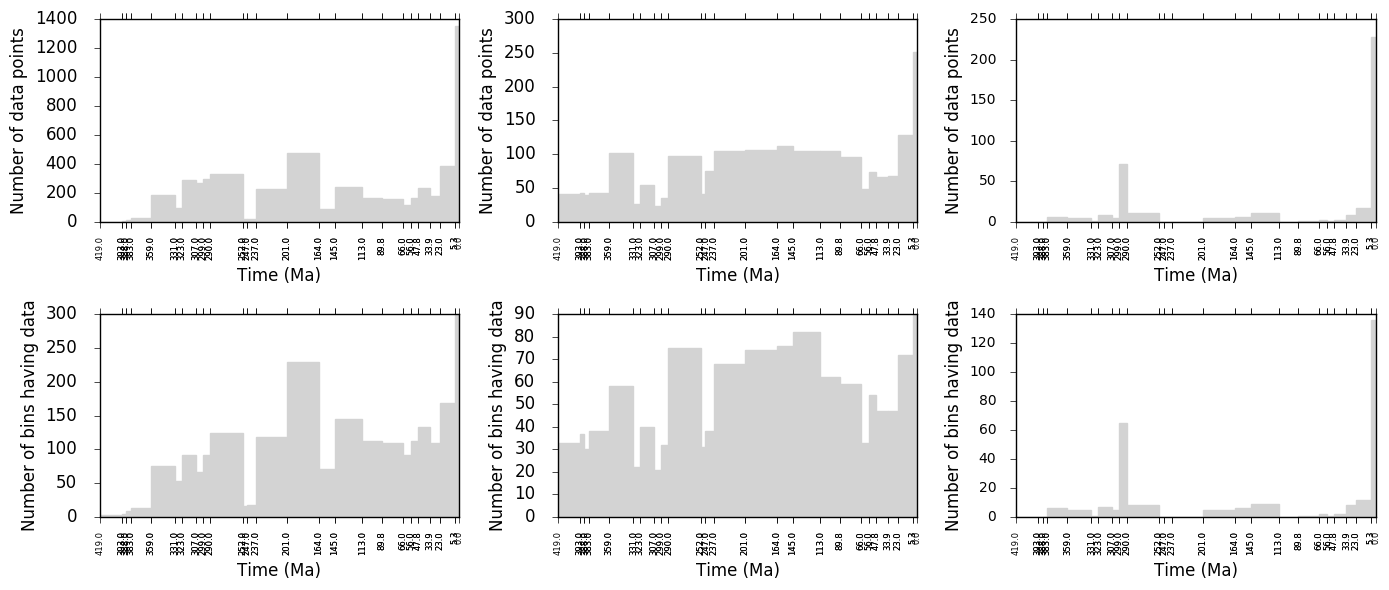

In [18]:
# read the data
Data = pd.read_excel('../Data/Fig02/Sum_LithData_Matthews2106_EachMap_410-0Ma.xlsx')
Data_bins = pd.read_excel('../Data/Fig02/Sum_Matthews2016_BinsHavingData_BinningSize5.xlsx')

# Plot the figure
fig ,axes = plt.subplots(nrows=2, ncols=3,figsize=(14,6),tight_layout=True) #tight_layout=True,sharex=True

bar_width = Data['Bar_Width']

##########################################
# coals
axes[0,0].bar(Data['MiddelAge'],Data['Sum_Coals'],bar_width,color='lightgrey',align='center',edgecolor='lightgrey') #,alpha=0.5

# set x axis
axes[0,0].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[0,0].set_xlim((419,0))
axes[0,0].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[0,0].xaxis.get_majorticklabels(), rotation=90)
axes[0,0].set_xlabel('Time (Ma)',fontsize=12)
axes[0,0].xaxis.set_ticks_position('both')
# set y axis
axes[0,0].yaxis.set_tick_params(labelsize=12,direction='out')
axes[0,0].yaxis.set_ticks_position('left')
axes[0,0].set_ylabel('Number of data points',fontsize=12)

# sum of bins having data
axes[1,0].bar(Data_bins['MiddelAge'],Data_bins['Sum_Coals'],bar_width,color='lightgrey',align='center',edgecolor='lightgrey')
# set x axis
axes[1,0].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[1,0].set_xlim((419,0))
axes[1,0].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=90)
axes[1,0].set_xlabel('Time (Ma)',fontsize=12)
axes[1,0].xaxis.set_ticks_position('both')
# set y axis
axes[1,0].yaxis.set_tick_params(labelsize=12,direction='out')
axes[1,0].yaxis.set_ticks_position('left')
axes[1,0].set_ylabel('Number of bins having data',fontsize=12)


##########################################
# Evaporites
axes[0,1].bar(Data['MiddelAge'],Data['Sum_Evaporites'], bar_width,color='lightgrey',align='center',edgecolor='lightgrey')
# set x axis
axes[0,1].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[0,1].set_xlim((419,0))
axes[0,1].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=90)
axes[0,1].set_xlabel('Time (Ma)',fontsize=12)
axes[0,1].xaxis.set_ticks_position('both')
# set y axis
axes[0,1].yaxis.set_tick_params(labelsize=12,direction='out')
axes[0,1].yaxis.set_ticks_position('left')
axes[0,1].set_ylabel('Number of data points',fontsize=12)

# sum of bins having data
axes[1,1].bar(Data_bins['MiddelAge'],Data_bins['Sum_Evaporites'],bar_width,color='lightgrey',align='center',edgecolor='lightgrey')
# set x axis
axes[1,1].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[1,1].set_xlim((419,0))
axes[1,1].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=90)
axes[1,1].set_xlabel('Time (Ma)',fontsize=12)
axes[1,1].xaxis.set_ticks_position('both')
# set y axis
axes[1,1].yaxis.set_tick_params(labelsize=12,direction='out')
axes[1,1].yaxis.set_ticks_position('left')
axes[1,1].set_ylabel('Number of bins having data',fontsize=12)


##########################################
# Glacial
axes[0,2].bar(Data['MiddelAge'],Data['Sum_Glacial'], bar_width,color='lightgrey',align='center',edgecolor='lightgrey')

# set x axis
axes[0,2].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[0,2].set_xlim((419,0))
axes[0,2].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[0,2].xaxis.get_majorticklabels(), rotation=90)
axes[0,2].set_xlabel('Time (Ma)',fontsize=12)
axes[0,2].xaxis.set_ticks_position('both')
# set y axis
axes[0,2].yaxis.set_tick_params(labelsize=10,direction='out')
axes[0,2].yaxis.set_ticks_position('left')
axes[0,2].set_ylabel('Number of data points',fontsize=12)

# sum of bins having data
axes[1,2].bar(Data_bins['MiddelAge'],Data_bins['Sum_Glacial'],bar_width,color='lightgrey',align='center',edgecolor='lightgrey')
# set x axis
axes[1,2].set_xticks(np.hstack((Data['FromAge'],Data['ToAge']))) #, rotation=50,,verticalalignment='top'
axes[1,2].set_xlim((419,0))
axes[1,2].xaxis.set_tick_params(labelsize=6,direction='out')
plt.setp(axes[1,2].xaxis.get_majorticklabels(), rotation=90)
axes[1,2].set_xlabel('Time (Ma)',fontsize=12)
axes[1,2].xaxis.set_ticks_position('both')

# set y axis
axes[1,2].set_ylabel('Number of bins having data',fontsize=12)
axes[1,2].yaxis.set_tick_params(labelsize=10,direction='out')
axes[1,2].yaxis.set_ticks_position('left')

#fig.subplots_adjust(hspace=0.2)
plt.savefig('Output/Fig_02.pdf')
plt.show()

## Figure 3

### Define the function

In [13]:
def get_paleolithology(point_features,rotation_model):
    pX = []
    pY = []
    pAge = []
    for point in point_features:
        lithcode = point.get_shapefile_attribute('LithCode')
        if lithcode == 'C' and point.get_reconstruction_plate_id()!=0:
        #if lithcode == 'E' and point.get_reconstruction_plate_id()!=0:
        #if lithcode== 'T' or lithcode=='D' or lithcode=='G' and point.get_reconstruction_plate_id()!=0:
            BirthTime = np.median(point.get_valid_time())
            if BirthTime<410:
                pAge.append(BirthTime)
                point_rotation = rotation_model.get_rotation(BirthTime, point.get_reconstruction_plate_id(), anchor_plate_id=0) #obtain rotating rules
                reconstructed_point = point_rotation * point.get_geometry() # carry out reconstruction
                pX.append(reconstructed_point.to_lat_lon()[1])
                pY.append(reconstructed_point.to_lat_lon()[0])         
    return pX,pY,pAge

### Data processing for removing the sampling bias

In [14]:
# remove the sampling bias
result_original = []
result_SamplingBiasRemoved = []
result_flipped = []
result_doubled = []

for i in np.arange(0,24,1):
    
    result = []
    result_0 = []
    result_1 = []
    result_2 = []
    result_3 = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #180, longtitude
    yedges = np.arange(-90, 91, 5) #90, latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    result_0 = np.nansum(data_hist[0], axis=0)
    result_original.append(result_0)
    #print type(result_original)
    
    # remove the sampling bias
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    result_SamplingBiasRemoved.append(result_1)
    
    #plt.pcolor(xedges,yedges,data_hist[0].T) #T means reverse the x, y axis
    
    # flip the data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    result_flipped.append(result_2) # add data on south hemisphere to north hemishpere
    #print result_flipped
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2) 
    result_doubled.append(np.array(result_3)) # add data on south hemisphere to north hemishpere
    #print result_doubled

print(xedges)
print(yedges)

[-180 -175 -170 -165 -160 -155 -150 -145 -140 -135 -130 -125 -120 -115 -110
 -105 -100  -95  -90  -85  -80  -75  -70  -65  -60  -55  -50  -45  -40  -35
  -30  -25  -20  -15  -10   -5    0    5   10   15   20   25   30   35   40
   45   50   55   60   65   70   75   80   85   90   95  100  105  110  115
  120  125  130  135  140  145  150  155  160  165  170  175  180]
[-90 -85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5
   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90]


/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide


### Make the figure

(37, 73)
(37, 73)
(73,)
(37,)
(36, 72)
24.0


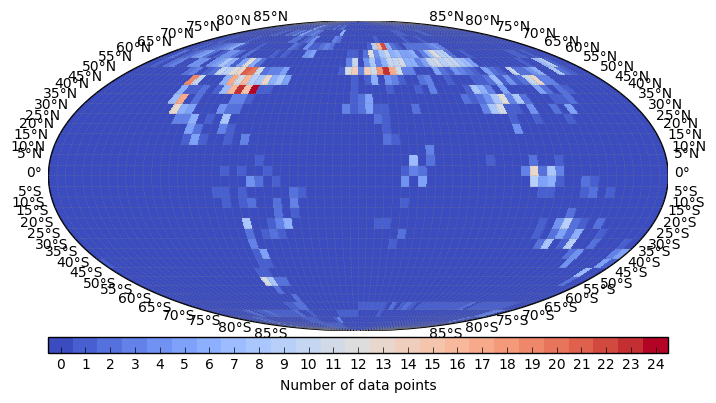

In [15]:

fig = plt.figure(figsize=(8,6))

m = Basemap(projection='moll',lat_0=0,lon_0=0,resolution='c',suppress_ticks=True)

xedges = np.arange(-180,181,5)
yedges = np.arange(-90,91,5)

px,py = np.meshgrid(xedges,yedges)
print(py.shape)
print(px.shape)

# pcolor or pcolormesh (they are same)
data = data_hist[0].T
cmap =plt.get_cmap('coolwarm', np.max(data)-np.min(data)+1) #binary, coolwarm, bwr
m.pcolormesh(px,py,data,latlon=True,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5) #T means reverse the x, y axis

# pcolor or pcolormesh on a basemap
#x,y = m(np.asarray(xedges),np.asarray(yedges))
print(xedges.shape) # longitude
print(yedges.shape) # latitude
print((data_hist[0].T).shape)

#x,y = m(xedges,yedges)
#m.pcolormesh(lon,lat,data_hist[0].T, latlon=True)


m.drawparallels(np.arange(-90, 91., 5.), labels=[1, 1, 0, 0],
                dashes=[1, 1], linewidth=0.25, color='0.5')
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 1, 1],
                dashes=[1, 1], linewidth=0.25, color='0.5')

print(np.min(data))
print(np.max(data))
cb = m.colorbar(location='bottom', label="Number of data points",ticks=np.arange(np.min(data),np.max(data)+1))

#plt.savefig('Fig2b.png',dpi=1000)
plt.savefig('Output/Fig_03b.pdf',dpi=600)
plt.show()

## Figure 3c

/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


nan


/Users/wenchaocao/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


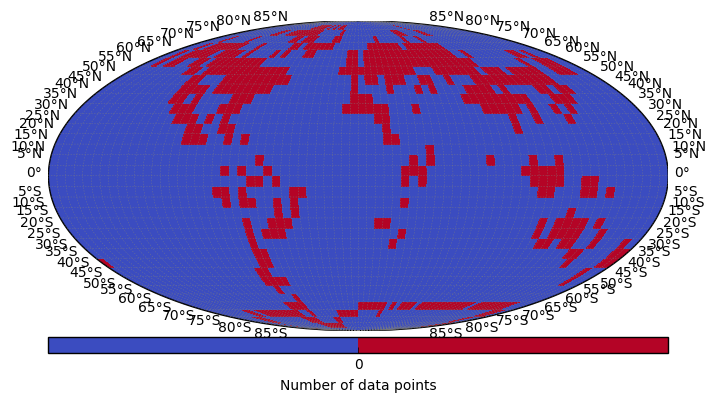

In [16]:
fig = plt.figure(figsize=(8,6))

m = Basemap(projection='moll',lat_0=0,lon_0=0,resolution='c',suppress_ticks=True)

data = (data_hist[0]/data_hist[0]).T
cmap =plt.get_cmap('coolwarm',2) # jet, coolwarm, bwr
m.pcolormesh(px,py,data,latlon=True,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5) #T means reverse the x, y axis

m.drawparallels(np.arange(-90, 91., 5.), labels=[1, 1, 0, 0],
                dashes=[1, 1], linewidth=0.25, color='0.5')
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 1, 1],
                dashes=[1, 1], linewidth=0.25, color='0.5')

print(np.min(data))
print(np.max(data))
cb = m.colorbar(location='bottom', label="Number of data points")
cb.set_ticks([0,1])

plt.savefig('Output/Fig_03c.pdf')
plt.show()


In [17]:
os.system('rm Output/*.png')

0